In [16]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.random import shuffle


import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from PIL import Image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(42)

In [17]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/data
/kaggle/input/data/images_003
/kaggle/input/data/images_003/images
/kaggle/input/data/images_012
/kaggle/input/data/images_012/images
/kaggle/input/data/images_009
/kaggle/input/data/images_009/images
/kaggle/input/data/images_008
/kaggle/input/data/images_008/images
/kaggle/input/data/images_007
/kaggle/input/data/images_007/images
/kaggle/input/data/images_010
/kaggle/input/data/images_010/images
/kaggle/input/data/images_002
/kaggle/input/data/images_002/images
/kaggle/input/data/images_011
/kaggle/input/data/images_011/images
/kaggle/input/data/images_001
/kaggle/input/data/images_001/images
/kaggle/input/data/images_005
/kaggle/input/data/images_005/images
/kaggle/input/data/images_004
/kaggle/input/data/images_004/images
/kaggle/input/data/images_006
/kaggle/input/data/images_006/images
/kaggle/input/chestxray8-dataframe


In [18]:
base_dir = "/kaggle/input/data"
updated_data_dir = '/kaggle/input/chestxray8-dataframe'

In [19]:
updated_labels = pd.read_csv(os.path.join(updated_data_dir,'train_df.csv'))
bad_labels = pd.read_csv(os.path.join(updated_data_dir,'cxr14_bad_labels.csv'))
labels = pd.read_csv(os.path.join(base_dir,"Data_Entry_2017.csv"))

In [20]:
labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [21]:
bad_labels.head()

,Unnamed: 0,Index,Inverted,Not frontal,Rotated
0,0,00000583_024.png,1.0,0.0,0.0
1,1,00002180_000.png,1.0,0.0,0.0
2,2,00002300_026.png,1.0,0.0,0.0
3,3,00002371_015.png,1.0,0.0,0.0
4,4,00006209_001.png,1.0,0.0,0.0


In [22]:
labels.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [23]:
labels = labels.drop(['Patient Age', 
                      'Patient Gender',
                      'OriginalImage[Width',
                      'Height]', 
                      'OriginalImagePixelSpacing[x', 
                      'y]', 
                      'Unnamed: 11'], axis=1)

In [24]:
labels.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,View Position
92746,00023154_000.png,Cardiomegaly|Effusion,0,23154,PA
80244,00019723_005.png,No Finding,5,19723,PA
80295,00019732_001.png,No Finding,1,19732,PA
31731,00008295_020.png,Mass,20,8295,PA
94687,00024424_000.png,No Finding,0,24424,PA


In [25]:
label_counts = labels['Finding Labels'].value_counts()

In [26]:
infiltration = label_counts.loc[label_counts.index.str.contains('Infiltration')]
atelectasis = label_counts.loc[label_counts.index.str.contains('Atelectasis')].index
both = infiltration.loc[infiltration.index.str.contains('Atelectasis')].index
infiltration = infiltration.index

In [27]:
print(infiltration.shape, atelectasis.shape, both.shape)

(366,) (318,) (139,)


In [28]:
infiltration = list(set(infiltration) - set(both))
atelectasis = list(set(atelectasis) - set(both))

In [29]:
print(len(infiltration), len(atelectasis), len(both))

227 179 139


In [30]:
infiltration_labels = labels.loc[labels['Finding Labels'].isin(infiltration)].reset_index(drop=True)
atelectasis_labels = labels.loc[labels['Finding Labels'].isin(atelectasis)].reset_index(drop=True)
normal_labels = labels.loc[labels['Finding Labels']=="No Finding"].reset_index(drop=True)

In [31]:
infiltration_labels['label'] = "Infiltration"
atelectasis_labels['label'] = "Atelectasis"
normal_labels['label'] = "Normal"

In [32]:
labels = pd.concat([normal_labels, atelectasis_labels, infiltration_labels])

In [33]:
labels = labels.loc[~labels['Image Index'].isin(bad_labels.Index)]

In [34]:
labels.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'View Position', 'label'],
      dtype='object')

In [35]:
labels['View Position'].value_counts()

PA    51755
AP    33329
Name: View Position, dtype: int64

In [36]:
labels['Follow-up #'].value_counts()

0      25866
1      10594
2       7089
3       5317
4       4244
       ...  
177        1
176        1
179        1
175        1
170        1
Name: Follow-up #, Length: 178, dtype: int64

In [37]:
labels['label'].value_counts()

Normal          60190
Infiltration    16610
Atelectasis      8284
Name: label, dtype: int64

In [38]:
labels = labels.merge(updated_labels[['Image Index', 'FilePath']], how='left', on='Image Index')

In [39]:
labels.loc[labels['label']=="Infiltration"].FilePath.values

array(['../input/data/images_001/images/00000003_003.png',
       '../input/data/images_001/images/00000005_006.png',
       '../input/data/images_001/images/00000005_007.png', ...,
       '../input/data/images_012/images/00030763_000.png',
       '../input/data/images_012/images/00030770_001.png',
       '../input/data/images_012/images/00030789_000.png'], dtype=object)

In [40]:
labels

,Image Index,Finding Labels,Follow-up #,Patient ID,View Position,label,FilePath
0,00000002_000.png,No Finding,0,2,PA,Normal,../input/data/images_001/images/00000002_000.png
1,00000005_000.png,No Finding,0,5,PA,Normal,../input/data/images_001/images/00000005_000.png
2,00000005_001.png,No Finding,1,5,AP,Normal,../input/data/images_001/images/00000005_001.png
3,00000005_002.png,No Finding,2,5,AP,Normal,../input/data/images_001/images/00000005_002.png
4,00000005_003.png,No Finding,3,5,PA,Normal,../input/data/images_001/images/00000005_003.png
...,...,...,...,...,...,...,...
85079,00030756_000.png,Infiltration,0,30756,PA,Infiltration,../input/data/images_012/images/00030756_000.png
85080,00030757_000.png,Infiltration,0,30757,PA,Infiltration,../input/data/images_012/images/00030757_000.png
85081,00030763_000.png,Infiltration,0,30763,PA,Infiltration,../input/data/images_012/images/00030763_000.png
85082,00030770_001.png,Infiltration,1,30770,AP,Infiltration,../input/data/images_012/images/00030770_001.png


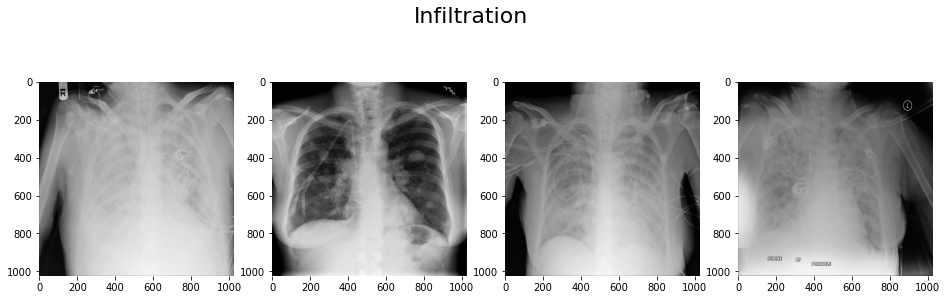

In [41]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Infiltration", size=22)
img_paths = labels.loc[labels['label']=="Infiltration"].FilePath.values
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = read_image(os.path.join(image))
    img = T.ToPILImage()(img)
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img, cmap = 'gray')
fig.show()

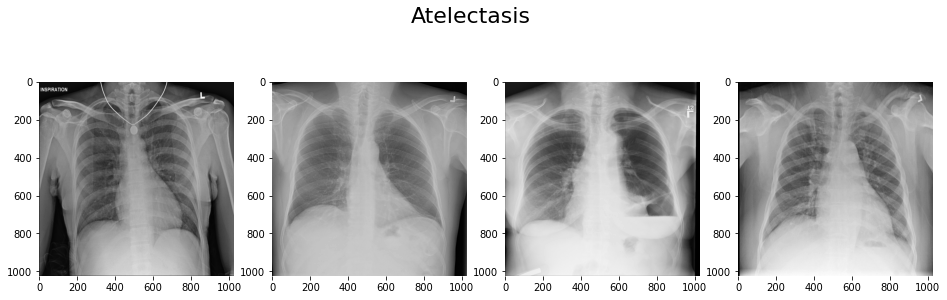

In [42]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Atelectasis", size=22)
img_paths = labels.loc[labels['label']=="Atelectasis"].FilePath.values
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = read_image(os.path.join(image))
    img = T.ToPILImage()(img)
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img, cmap = 'gray')
fig.show()

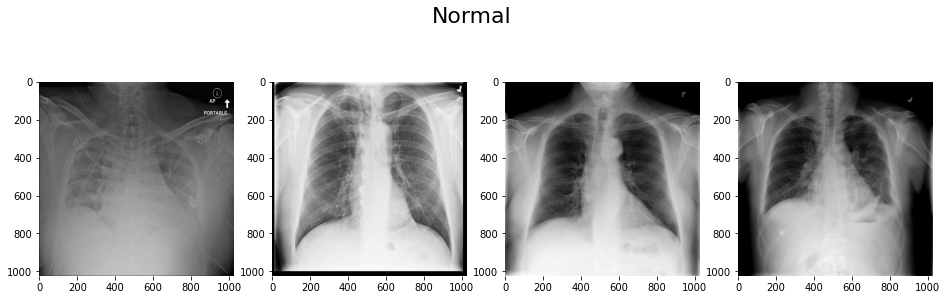

In [43]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Normal", size=22)
img_paths = labels.loc[labels['label']=="Normal"].FilePath.values
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = read_image(os.path.join(image))
    img = T.ToPILImage()(img)
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img, cmap = 'gray')
fig.show()

In [107]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap = 'gray', **imshow_kwargs)
            #ax.imshow(np.asarray(img), cmap = 'gray', **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [73]:
file_paths = labels.FilePath.values
shuffle(file_paths)

In [102]:
orig_img = read_image(file_paths[0])

In [93]:
plt.rcParams["figure.figsize"] = (20,6)

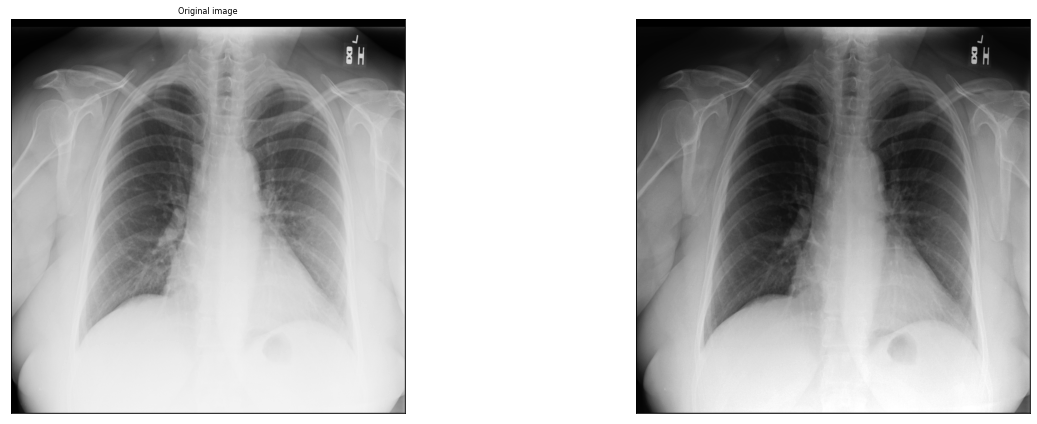

In [108]:
blurred_imgs = [T.functional.equalize(orig_img) for _ in range(1)]
plot(blurred_imgs)

In [95]:
plt.rcParams["figure.figsize"] = (20,6)

In [109]:
0.3 * ((5 - 1) * 0.5 - 1) + 0.8

1.1

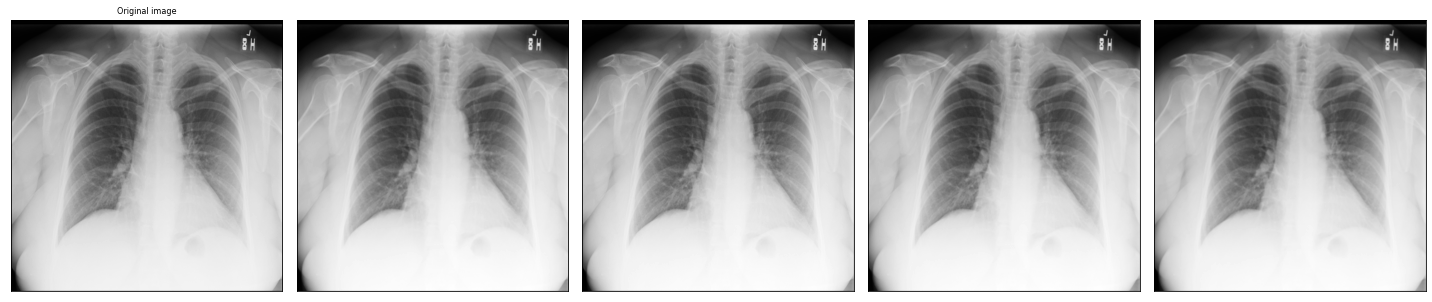

In [110]:
blurred_imgs = [T.functional.gaussian_blur(orig_img, kernel_size=(5, 5), sigma=None), 
                T.functional.gaussian_blur(orig_img, kernel_size=(5, 5), sigma=(0.5, 0.5)),
                T.functional.gaussian_blur(orig_img, kernel_size=(5, 5), sigma=(1, 1)),
                T.functional.gaussian_blur(orig_img, kernel_size=(5, 5), sigma=(2, 2))
                ]
plot(blurred_imgs)

In [111]:
labels

,Image Index,Finding Labels,Follow-up #,Patient ID,View Position,label,FilePath
0,00000002_000.png,No Finding,0,2,PA,Normal,../input/data/images_005/images/00011369_000.png
1,00000005_000.png,No Finding,0,5,PA,Normal,../input/data/images_012/images/00028720_000.png
2,00000005_001.png,No Finding,1,5,AP,Normal,../input/data/images_006/images/00012089_006.png
3,00000005_002.png,No Finding,2,5,AP,Normal,../input/data/images_006/images/00011702_069.png
4,00000005_003.png,No Finding,3,5,PA,Normal,../input/data/images_008/images/00018318_003.png
...,...,...,...,...,...,...,...
85079,00030756_000.png,Infiltration,0,30756,PA,Infiltration,../input/data/images_004/images/00007846_002.png
85080,00030757_000.png,Infiltration,0,30757,PA,Infiltration,../input/data/images_011/images/00027415_013.png
85081,00030763_000.png,Infiltration,0,30763,PA,Infiltration,../input/data/images_009/images/00019333_003.png
85082,00030770_001.png,Infiltration,1,30770,AP,Infiltration,../input/data/images_003/images/00006134_005.png
